# Data Preprocessing for Mindfulness Prediction

This notebook prepares the extracted features for machine learning models.

**Steps**:
1. Load feature matrix from feature engineering
2. Handle missing values (imputation)
3. Feature scaling (StandardScaler, MinMaxScaler)
4. Train/test split (stratified by label)
5. Feature selection (optional)
6. Save preprocessed data for modeling

**Input**: `data/processed/S2_features.csv`  
**Output**: `data/processed/S2_preprocessed.pkl`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Preprocessing tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


## 1. Load Feature Matrix

Load the features extracted in the previous notebook.

In [2]:
# Load feature matrix
DATA_DIR = Path('../data/processed')
subject_id = 'S2'

features_path = DATA_DIR / f'{subject_id}_features.csv'

if not features_path.exists():
    print(f"ERROR: Feature file not found: {features_path}")
    print("Please run 02_feature_engineering.ipynb first to generate features.")
else:
    features_df = pd.read_csv(features_path)
    print(f"✓ Loaded feature matrix: {features_df.shape}")
    print(f"  Rows (windows): {len(features_df)}")
    print(f"  Columns (features + metadata): {len(features_df.columns)}")
    
    # Display first few rows
    print("\nFirst 3 rows:")
    display(features_df.head(3))

✓ Loaded feature matrix: (48, 49)
  Rows (windows): 48
  Columns (features + metadata): 49

First 3 rows:


,rmssd,sdnn,pnn50,mean_hr,std_hr,min_hr,max_hr,hr_range,lf_power,hf_power,...,temp_slope,activity_mean,activity_std,activity_max,activity_level,posture_stability,window_start,window_end,label,mindfulness_index
0,109.091251,108.803311,24.675325,81.049508,10.418164,49.822064,96.330275,46.508211,2592.643009,3397.318664,...,0.000100,0.937691,0.024250,1.217648,3.697619,0.976324,210000,252000,1,1.0
1,53.688444,77.470565,30.000000,71.869557,7.232138,62.686567,93.959732,31.273164,2232.933820,639.623357,...,-0.004329,0.952891,0.004522,0.982940,13.102381,0.995498,252000,294000,1,1.0
2,110.655628,102.638639,39.436620,73.881958,8.082719,42.338710,97.447796,55.109086,3722.015936,6395.301021,...,0.000159,0.951266,0.007707,1.034227,7.547619,0.992352,294000,336000,1,1.0


## 2. Separate Features and Target

Split the DataFrame into:
- **Features (X)**: Physiological features
- **Target (y)**: Mindfulness index
- **Metadata**: Window indices, labels

In [3]:
# Define metadata columns to exclude from features
metadata_cols = ['window_start', 'window_end', 'label', 'mindfulness_index']

# Separate features and target
X = features_df.drop(columns=metadata_cols)
y = features_df['mindfulness_index']
metadata = features_df[['window_start', 'window_end', 'label']]

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(list(X.columns[:10]), "...")  # Show first 10

# Check target distribution
print(f"\nTarget (mindfulness_index) distribution:")
print(y.describe())

Features (X): (48, 45)
Target (y): (48,)

Feature columns (45):
['rmssd', 'sdnn', 'pnn50', 'mean_hr', 'std_hr', 'min_hr', 'max_hr', 'hr_range', 'lf_power', 'hf_power'] ...

Target (mindfulness_index) distribution:
count    48.000000
mean      0.727083
std       0.388527
min       0.000000
25%       0.700000
50%       0.900000
75%       1.000000
max       1.000000
Name: mindfulness_index, dtype: float64


## 3. Analyze Missing Values

Identify features with missing data and decide on imputation strategy.

In [4]:
# Calculate missing value percentages
missing_counts = X.isnull().sum()
missing_pct = (missing_counts / len(X)) * 100
missing_df = pd.DataFrame({
    'Feature': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Pct': missing_pct.values
})

# Filter to features with missing values
missing_features = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Pct', ascending=False)

if len(missing_features) > 0:
    print(f"Features with missing values: {len(missing_features)}")
    print("\nTop 10 features by missing percentage:")
    print(missing_features.head(10))
    
    # Visualize
    if len(missing_features) > 0:
        plt.figure(figsize=(12, 6))
        top_missing = missing_features.head(15)
        plt.barh(range(len(top_missing)), top_missing['Missing_Pct'].values)
        plt.yticks(range(len(top_missing)), top_missing['Feature'].values)
        plt.xlabel('Missing Percentage (%)')
        plt.title('Top 15 Features with Missing Values')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
else:
    print("✓ No missing values found!")

✓ No missing values found!


## 4. Handle Missing Values

**Strategy**:
- Features with >50% missing: Drop
- Features with <50% missing: Impute with median (robust to outliers)
- Alternative: KNN imputation for better results

In [5]:
# Define threshold for dropping features
DROP_THRESHOLD = 50  # Drop features with >50% missing

# Identify features to drop
features_to_drop = missing_features[missing_features['Missing_Pct'] > DROP_THRESHOLD]['Feature'].tolist()

if len(features_to_drop) > 0:
    print(f"Dropping {len(features_to_drop)} features with >{DROP_THRESHOLD}% missing:")
    print(features_to_drop)
    X_cleaned = X.drop(columns=features_to_drop)
else:
    print(f"✓ No features exceed {DROP_THRESHOLD}% missing threshold")
    X_cleaned = X.copy()

print(f"\nFeatures after dropping: {X_cleaned.shape}")

# Impute remaining missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X_cleaned),
    columns=X_cleaned.columns,
    index=X_cleaned.index
)

# Verify no missing values remain
remaining_missing = X_imputed.isnull().sum().sum()
print(f"\n✓ Imputation complete. Remaining missing values: {remaining_missing}")
print(f"Final feature matrix: {X_imputed.shape}")

✓ No features exceed 50% missing threshold

Features after dropping: (48, 45)

✓ Imputation complete. Remaining missing values: 0
Final feature matrix: (48, 45)


## 5. Feature Scaling

Scale features to have similar ranges for ML algorithms.

**Options**:
- **StandardScaler**: Mean=0, Std=1 (assumes normal distribution)
- **MinMaxScaler**: Scale to [0, 1] range
- **RobustScaler**: Uses median and IQR (robust to outliers)

We'll use **StandardScaler** as it's most common for regression.

In [6]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_imputed),
    columns=X_imputed.columns,
    index=X_imputed.index
)

print(f"✓ Features scaled using StandardScaler")
print(f"Scaled feature matrix: {X_scaled.shape}")

# Verify scaling
print("\nScaling verification (should be ~0 mean, ~1 std):")
print(f"Mean: {X_scaled.mean().mean():.6f}")
print(f"Std: {X_scaled.std().mean():.6f}")

# Show before/after for a sample feature
sample_feature = X_imputed.columns[0]
print(f"\nExample feature: {sample_feature}")
print(f"Before scaling - Mean: {X_imputed[sample_feature].mean():.4f}, Std: {X_imputed[sample_feature].std():.4f}")
print(f"After scaling  - Mean: {X_scaled[sample_feature].mean():.4f}, Std: {X_scaled[sample_feature].std():.4f}")

✓ Features scaled using StandardScaler
Scaled feature matrix: (48, 45)

Scaling verification (should be ~0 mean, ~1 std):
Mean: -0.000000
Std: 1.010582

Example feature: rmssd
Before scaling - Mean: 68.0686, Std: 22.1829
After scaling  - Mean: 0.0000, Std: 1.0106


## 6. Train/Test Split

Split data into training and testing sets.

**Strategy**: Stratified split by label to maintain class distribution

In [7]:
# Set random seed for reproducibility
RANDOM_STATE = 42
TEST_SIZE = 0.2  # 80% train, 20% test

# Stratify by label to maintain distribution
stratify_labels = metadata['label']

X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_scaled, y, metadata,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=stratify_labels
)

print(f"✓ Train/test split complete")
print(f"\nTraining set: {X_train.shape}")
print(f"Testing set:  {X_test.shape}")

# Verify stratification
print("\nLabel distribution:")
print("\nTraining set:")
print(meta_train['label'].value_counts().sort_index())
print("\nTesting set:")
print(meta_test['label'].value_counts().sort_index())

# Target distribution
print("\nTarget (mindfulness_index) distribution:")
print(f"Train - Mean: {y_train.mean():.3f}, Std: {y_train.std():.3f}")
print(f"Test  - Mean: {y_test.mean():.3f}, Std: {y_test.std():.3f}")

✓ Train/test split complete

Training set: (38, 45)
Testing set:  (10, 45)

Label distribution:

Training set:
label
1    15
2     8
3     5
4    10
Name: count, dtype: int64

Testing set:
label
1    4
2    2
3    1
4    3
Name: count, dtype: int64

Target (mindfulness_index) distribution:
Train - Mean: 0.724, Std: 0.391
Test  - Mean: 0.740, Std: 0.401


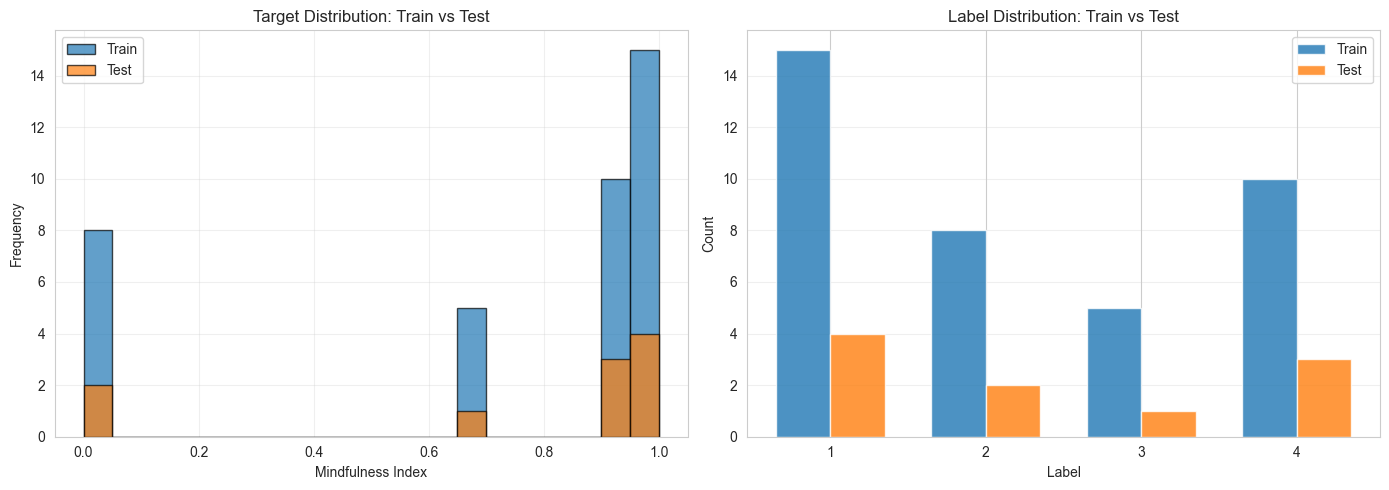

In [8]:
# Visualize train/test split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Target distribution
axes[0].hist(y_train, bins=20, alpha=0.7, label='Train', edgecolor='black')
axes[0].hist(y_test, bins=20, alpha=0.7, label='Test', edgecolor='black')
axes[0].set_xlabel('Mindfulness Index')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution: Train vs Test')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Label distribution
train_label_counts = meta_train['label'].value_counts().sort_index()
test_label_counts = meta_test['label'].value_counts().sort_index()

x = np.arange(len(train_label_counts))
width = 0.35

axes[1].bar(x - width/2, train_label_counts.values, width, label='Train', alpha=0.8)
axes[1].bar(x + width/2, test_label_counts.values, width, label='Test', alpha=0.8)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Label Distribution: Train vs Test')
axes[1].set_xticks(x)
axes[1].set_xticklabels(train_label_counts.index)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Feature Selection (Optional)

Remove low-variance or redundant features to improve model performance.

**Methods**:
1. **Variance Threshold**: Remove features with low variance
2. **Correlation Filter**: Remove highly correlated features
3. **SelectKBest**: Select top K features by statistical test

In [9]:
# 1. Variance Threshold - Remove features with very low variance
variance_threshold = 0.01  # Features with variance < 0.01 are nearly constant

selector = VarianceThreshold(threshold=variance_threshold)
X_train_var = selector.fit_transform(X_train)
X_test_var = selector.transform(X_test)

# Get selected feature names
selected_features = X_train.columns[selector.get_support()].tolist()
removed_features = X_train.columns[~selector.get_support()].tolist()

print(f"Variance Threshold ({variance_threshold}):")
print(f"  Features kept: {len(selected_features)}")
print(f"  Features removed: {len(removed_features)}")

if len(removed_features) > 0:
    print(f"\nRemoved features: {removed_features[:5]}...")  # Show first 5

# Convert back to DataFrame
X_train_selected = pd.DataFrame(X_train_var, columns=selected_features, index=X_train.index)
X_test_selected = pd.DataFrame(X_test_var, columns=selected_features, index=X_test.index)

print(f"\nFinal feature matrix after selection:")
print(f"  Train: {X_train_selected.shape}")
print(f"  Test: {X_test_selected.shape}")

Variance Threshold (0.01):
  Features kept: 45
  Features removed: 0

Final feature matrix after selection:
  Train: (38, 45)
  Test: (10, 45)


## 8. Save Preprocessed Data

Save all preprocessed data for use in modeling notebooks.

In [10]:
# Package all preprocessed data
preprocessed_data = {
    'X_train': X_train_selected,
    'X_test': X_test_selected,
    'y_train': y_train,
    'y_test': y_test,
    'meta_train': meta_train,
    'meta_test': meta_test,
    'feature_names': selected_features,
    'scaler': scaler,
    'imputer': imputer,
    'variance_selector': selector,
    'metadata': {
        'subject_id': subject_id,
        'n_features_original': len(X.columns),
        'n_features_final': len(selected_features),
        'n_train': len(X_train),
        'n_test': len(X_test),
        'test_size': TEST_SIZE,
        'random_state': RANDOM_STATE,
        'scaling_method': 'StandardScaler',
        'imputation_strategy': 'median'
    }
}

# Save to pickle file
output_path = DATA_DIR / f'{subject_id}_preprocessed.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(preprocessed_data, f)

print(f"✓ Preprocessed data saved to: {output_path}")

# Also save as CSV for easy inspection
X_train_selected.to_csv(DATA_DIR / f'{subject_id}_X_train.csv', index=False)
X_test_selected.to_csv(DATA_DIR / f'{subject_id}_X_test.csv', index=False)
y_train.to_csv(DATA_DIR / f'{subject_id}_y_train.csv', index=False, header=['mindfulness_index'])
y_test.to_csv(DATA_DIR / f'{subject_id}_y_test.csv', index=False, header=['mindfulness_index'])

print(f"✓ CSV files saved for inspection")

print(f"\n{'='*60}")
print("Preprocessing Complete!")
print(f"{'='*60}")
print(f"Subject: {subject_id}")
print(f"Original features: {len(X.columns)}")
print(f"Final features: {len(selected_features)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"\nReady for modeling!")

✓ Preprocessed data saved to: ../data/processed/S2_preprocessed.pkl
✓ CSV files saved for inspection

Preprocessing Complete!
Subject: S2
Original features: 45
Final features: 45
Training samples: 38
Testing samples: 10

Ready for modeling!


## Summary

**Preprocessing Steps Completed**:
1. ✓ Loaded feature matrix
2. ✓ Handled missing values (dropped >50% missing, imputed rest with median)
3. ✓ Scaled features (StandardScaler)
4. ✓ Train/test split (80/20, stratified by label)
5. ✓ Feature selection (variance threshold)
6. ✓ Saved preprocessed data

**Next Steps**:
- **Notebook 04**: Linear Regression model
- **Notebook 05**: Random Forest & XGBoost models
- **Notebooks 06-07**: Literature-based methods

**Files Created**:
- `S2_preprocessed.pkl` - Complete preprocessed dataset
- `S2_X_train.csv`, `S2_X_test.csv` - Feature matrices
- `S2_y_train.csv`, `S2_y_test.csv` - Target variables

(03_preprocessing.ipynb) that handles all data preparation for your ML models:

What's Included:

📥 Load Features: Imports feature matrix from notebook 02
🔍 Missing Value Analysis: Identifies and visualizes missing data
🛠️ Imputation: Drops features >50% missing, imputes rest with median
⚖️ Feature Scaling: StandardScaler (mean=0, std=1)
✂️ Train/Test Split: 80/20 stratified by label (maintains distribution)
🎯 Feature Selection: Variance threshold to remove low-variance features
💾 Data Export: Saves to pickle + CSV files
Output Files:

S2_preprocessed.pkl - Complete dataset with scalers
S2_X_train.csv, S2_X_test.csv - Feature matrices
S2_y_train.csv, S2_y_test.csv - Target variables



Next Steps: You're now ready for Phase 3: Classical ML Models! Would you like me to create the model training notebooks (Linear Regression, Random Forest, XGBoost)?